In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    MobileNet,
    Xception,
    ResNet50V2,
    DenseNet201,
    DenseNet169,
    InceptionV3,
    InceptionResNetV2,
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

### Cell 2: Preprocessing and Data Loading Functions


In [2]:
def preprocess_aptos_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    return img


def load_data(image_dir, csv_file, target_size=(224, 224), label_column="diagnosis"):
    df = pd.read_csv(csv_file)
    images = []
    labels = []
    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, row["id_code"] + ".png")
        img = preprocess_aptos_image(img_path, target_size)
        images.append(img)
        labels.append(row[label_column])
    return np.array(images), np.array(labels)


# Load data
train_images, train_labels = load_data(
    "aptos2019-blindness-detection/train_images",
    "aptos2019-blindness-detection/train.csv",
)


# split data
# X_train,y_train= train_images, train_labels
# _, X_val, _, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

### Cell 3: Function to Create, Compile, and Train Model


In [3]:
def add_dense_layer(base_model, num_classes=5):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def compile_model_with_dense(model):
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


# Use KFold cross-validation for model training
def cross_validate_model(model, X, y, folds=5, epochs=10):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    fold_no = 1
    history_list = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        print(f"Training Fold {fold_no}...")
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            verbose=1,
        )
        history_list.append(history)
        fold_no += 1
    return history_list

In [4]:
EPOCHS = 30
FOLDS=5

### Cell 4: MobileNet Model Cross-Validation and Visualization


In [5]:
# MobileNet
base_model_mobilenet = MobileNet(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
mobilenet_model = add_dense_layer(base_model_mobilenet)
mobilenet_model = compile_model_with_dense(mobilenet_model)

# Train MobileNet model using cross-validation
mobilenet_history = cross_validate_model(
    mobilenet_model, train_images, train_labels, folds=FOLDS, epochs=EPOCHS
)

# Average accuracy and validation accuracy across all folds
avg_train_accuracy_mobilenet = np.mean([history.history['accuracy'] for history in mobilenet_history], axis=0)
avg_val_accuracy_mobilenet = np.mean([history.history['val_accuracy'] for history in mobilenet_history], axis=0)

# Plot average accuracy for all folds for MobileNet
plt.plot(avg_train_accuracy_mobilenet, label='Average Train Accuracy')
plt.plot(avg_val_accuracy_mobilenet, label='Average Val Accuracy')

plt.title('MobileNet Average Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion matrix for MobileNet during testing
kf = KFold(n_splits=5, shuffle=True, random_state=42)
conf_matrix_sum_mobilenet = np.zeros((5, 5))  # Adjust size if you have a different number of classes

for train_index, val_index in kf.split(train_images):
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]
    y_pred_mobilenet = np.argmax(mobilenet_model.predict(X_val), axis=1)

    conf_matrix_mobilenet = confusion_matrix(y_val, y_pred_mobilenet)
    conf_matrix_sum_mobilenet += conf_matrix_mobilenet

# Average and normalize the confusion matrix
conf_matrix_avg_mobilenet = conf_matrix_sum_mobilenet / kf.get_n_splits()
conf_matrix_norm_avg_mobilenet = conf_matrix_avg_mobilenet / conf_matrix_avg_mobilenet.sum(axis=1)[:, np.newaxis]

# Plot normalized average confusion matrix for MobileNet
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_norm_avg_mobilenet, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Average Confusion Matrix - MobileNet')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Extract final metrics from history
train_accuracy = mobilenet_history.history['accuracy'][-1]
val_accuracy = mobilenet_history.history['val_accuracy'][-1]
train_precision = mobilenet_history.history['precision'][-1]
val_precision = mobilenet_history.history['val_precision'][-1]
train_recall = mobilenet_history.history['recall'][-1]
val_recall = mobilenet_history.history['val_recall'][-1]
train_loss = mobilenet_history.history['loss'][-1]
val_loss = mobilenet_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)

Training Fold 1...
Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.6566 - loss: 1.2019

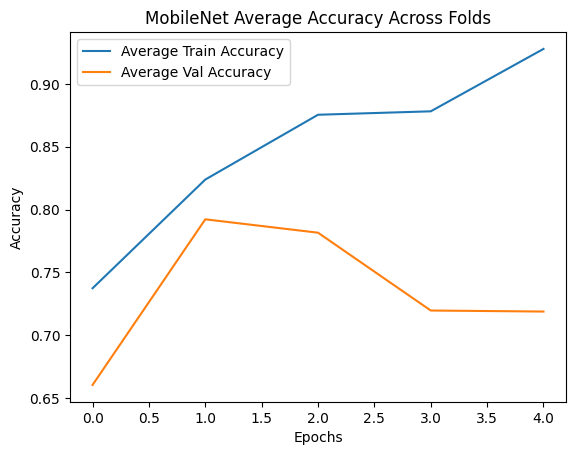

Training Fold 1...
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.6132 - loss: 1.0876 - val_accuracy: 0.5756 - val_loss: 6.2976
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7742 - loss: 0.6054 - val_accuracy: 0.7395 - val_loss: 1.6942
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7970 - loss: 0.5476 - val_accuracy: 0.7493 - val_loss: 1.8844
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.8506 - loss: 0.3949 - val_accuracy: 0.7258 - val_loss: 0.9123
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8652 - loss: 0.3421 - val_accuracy: 0.7133 - val_loss: 1.4277
Training Fold 2...
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7711 - loss: 0.6401 - val_accuracy: 0.5025 - val_loss: 1.6006
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.8200 - loss: 0.5187 - val_accuracy: 0.7979 - val_loss: 0.5517
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.8740 - loss: 0.3

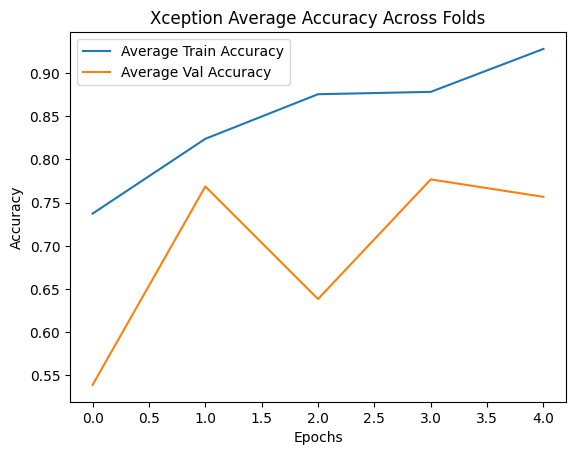

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step


ValueError: Found input variables with inconsistent numbers of samples: [733, 732]

In [17]:
# Xception
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
xception_model = add_dense_layer(base_model_xception)
xception_model = compile_model_with_dense(xception_model)

# Train Xception model using cross-validation
xception_history = cross_validate_model(xception_model, train_images, train_labels, folds=FOLDS, epochs=EPOCHS)

# Visualize Accuracy for all folds for Xception
avg_train_accuracy_xception = np.mean([history.history['accuracy'] for history in mobilenet_history], axis=0)
avg_val_accuracy_xception = np.mean([history.history['val_accuracy'] for history in xception_history], axis=0)

# Plot average accuracy for all folds for Xception
plt.plot(avg_train_accuracy_xception, label='Average Train Accuracy')
plt.plot(avg_val_accuracy_xception, label='Average Val Accuracy')

plt.title('Xception Average Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion matrix for Xception during testing
conf_matrix_sum_xception = np.zeros((5, 5))  # Adjust size if you have a different number of classes

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(train_images):
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Predict using Xception model
    y_pred_xception = np.argmax(xception_model.predict(X_val), axis=1)

    # Compute confusion matrix for Xception model
    conf_matrix_xception = confusion_matrix(y_val, y_pred_xception, labels=np.arange(5))
    conf_matrix_sum_xception += conf_matrix_xception

# Average and normalize the confusion matrix
conf_matrix_avg_xception = conf_matrix_sum_xception / kf.get_n_splits()
conf_matrix_norm_avg_xception = conf_matrix_avg_xception / conf_matrix_avg_xception.sum(axis=1)[:, np.newaxis]

# Plot normalized average confusion matrix for Xception
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_norm_avg_xception, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Average Confusion Matrix - Xception')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Extract final metrics from history
train_accuracy = xception_history.history['accuracy'][-1]
val_accuracy = xception_history.history['val_accuracy'][-1]
train_precision = xception_history.history['precision'][-1]
val_precision = xception_history.history['val_precision'][-1]
train_recall = xception_history.history['recall'][-1]
val_recall = xception_history.history['val_recall'][-1]
train_loss = xception_history.history['loss'][-1]
val_loss = xception_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)

Training Fold 1...
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6516 - loss: 1.0452 - val_accuracy: 0.5516 - val_loss: 4.5929
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7397 - loss: 0.6945 - val_accuracy: 0.7138 - val_loss: 1.6455
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7545 - loss: 0.6355 - val_accuracy: 0.7302 - val_loss: 1.0721
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8067 - loss: 0.5516 - val_accuracy: 0.6985 - val_loss: 1.6549
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7995 - loss: 0.5194 - val_accuracy: 0.7258 - val_loss: 1.0499
Training Fold 2...
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7799 - loss: 0.6099 - val_accuracy: 0.7564 - val_loss: 0.6545
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7950 - loss: 0.5521 - val_accuracy: 0.8061 - val_loss: 0.5476
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8219 - loss: 0.4379 - v

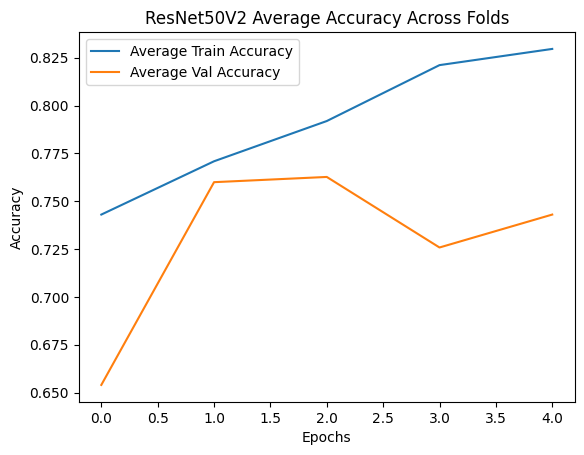

23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 322ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step


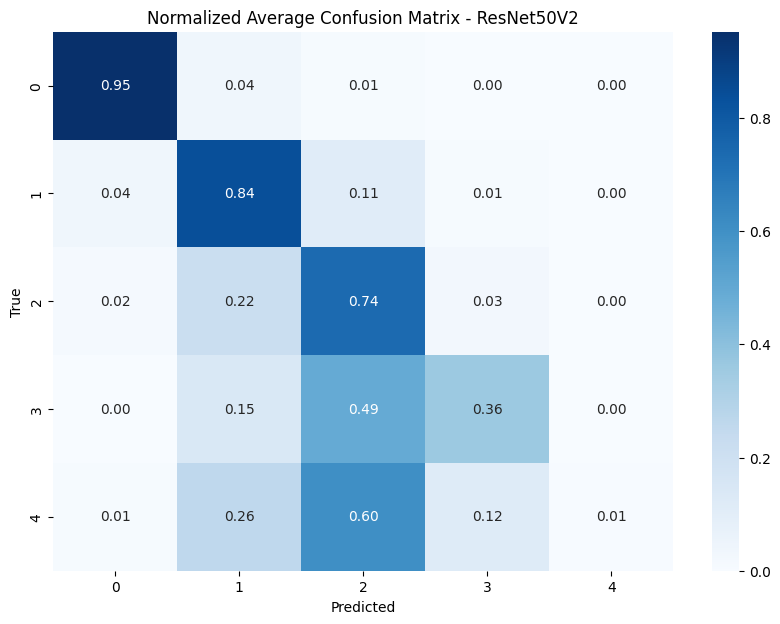

In [20]:
# ResNet50V2
base_model_ResNet50V2 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
ResNet50V2_model = add_dense_layer(base_model_ResNet50V2)
ResNet50V2_model = compile_model_with_dense(ResNet50V2_model)

# Train ResNet50V2 model using cross-validation
ResNet50V2_history = cross_validate_model(ResNet50V2_model, train_images, train_labels, folds=FOLDS, epochs=EPOCHS)

# Visualize Accuracy for all folds for ResNet50V2
avg_train_accuracy_ResNet50V2 = np.mean([history.history['accuracy'] for history in ResNet50V2_history], axis=0)
avg_val_accuracy_ResNet50V2 = np.mean([history.history['val_accuracy'] for history in ResNet50V2_history], axis=0)

# Plot average accuracy for all folds for ResNet50V2
plt.plot(avg_train_accuracy_ResNet50V2, label='Average Train Accuracy')
plt.plot(avg_val_accuracy_ResNet50V2, label='Average Val Accuracy')

plt.title('ResNet50V2 Average Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion matrix for ResNet50V2 during testing
conf_matrix_sum_ResNet50V2 = np.zeros((5, 5))  # Adjust size if you have a different number of classes

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(train_images):
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Predict using ResNet50V2 model
    y_pred_ResNet50V2 = np.argmax(ResNet50V2_model.predict(X_val), axis=1)

    # Compute confusion matrix for ResNet50V2 model
    conf_matrix_ResNet50V2 = confusion_matrix(y_val, y_pred_ResNet50V2, labels=np.arange(5))
    conf_matrix_sum_ResNet50V2 += conf_matrix_ResNet50V2

# Average and normalize the confusion matrix
conf_matrix_avg_ResNet50V2 = conf_matrix_sum_ResNet50V2 / kf.get_n_splits()
conf_matrix_norm_avg_ResNet50V2 = conf_matrix_avg_ResNet50V2 / conf_matrix_avg_ResNet50V2.sum(axis=1)[:, np.newaxis]

# Plot normalized average confusion matrix for ResNet50V2
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_norm_avg_ResNet50V2, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Average Confusion Matrix - ResNet50V2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Extract final metrics from history
train_accuracy = ResNet50V2_history.history['accuracy'][-1]
val_accuracy = ResNet50V2_history.history['val_accuracy'][-1]
train_precision = ResNet50V2_history.history['precision'][-1]
val_precision = ResNet50V2_history.history['val_precision'][-1]
train_recall = ResNet50V2_history.history['recall'][-1]
val_recall = ResNet50V2_history.history['val_recall'][-1]
train_loss = ResNet50V2_history.history['loss'][-1]
val_loss = ResNet50V2_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)

Training Fold 1...
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - accuracy: 0.6351 - loss: 1.0941 - val_accuracy: 0.4801 - val_loss: 2238.8833
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.7882 - loss: 0.5530 - val_accuracy: 0.4801 - val_loss: 409.3874
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.7673 - loss: 0.6124 - val_accuracy: 0.4528 - val_loss: 22.9059
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.7646 - loss: 0.6945 - val_accuracy: 0.4801 - val_loss: 576500.1250
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.7720 - loss: 0.6477 - val_accuracy: 0.2802 - val_loss: 7.8838
Training Fold 2...
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.7578 - loss: 0.7109 - val_accuracy: 0.7149 - val_loss: 1.0966
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.7872 - loss: 0.6000 - val_accuracy: 0.2660 - val_loss: 99.8836
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.7423

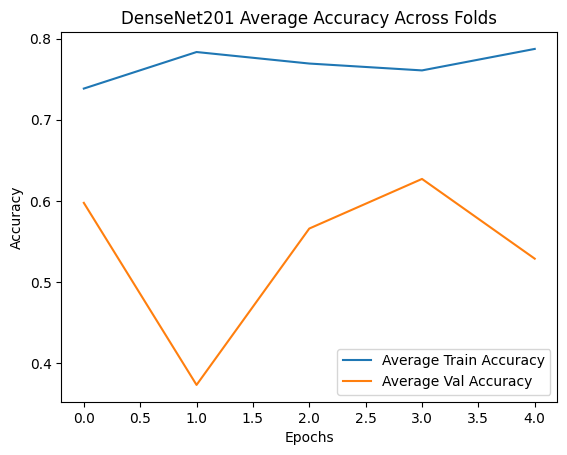

23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 746ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 640ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 628ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 638ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 635ms/step


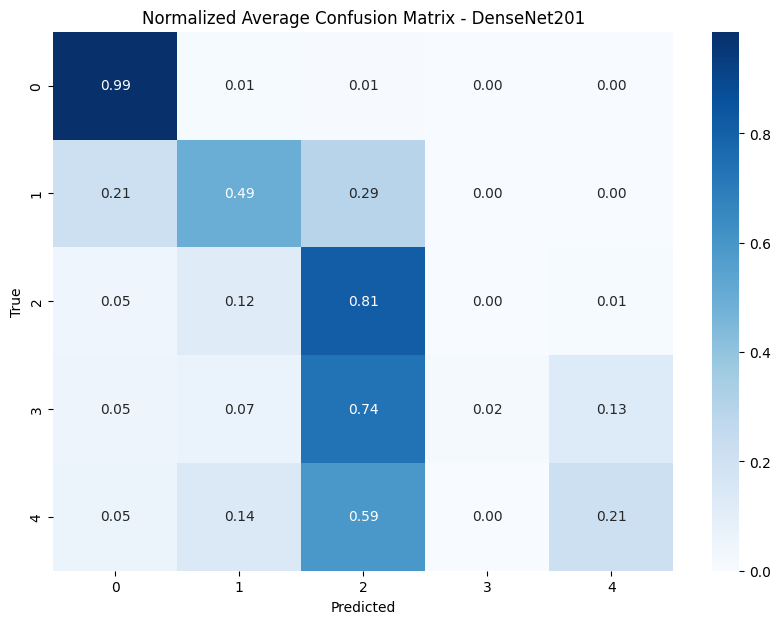

In [21]:
# DenseNet201
base_model_DenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
DenseNet201_model = add_dense_layer(base_model_DenseNet201)
DenseNet201_model = compile_model_with_dense(DenseNet201_model)

# Train DenseNet201 model using cross-validation
DenseNet201_history = cross_validate_model(DenseNet201_model, train_images, train_labels, folds=FOLDS, epochs=EPOCHS)

# Visualize Accuracy for all folds for DenseNet201
avg_train_accuracy_DenseNet201 = np.mean([history.history['accuracy'] for history in DenseNet201_history], axis=0)
avg_val_accuracy_DenseNet201 = np.mean([history.history['val_accuracy'] for history in DenseNet201_history], axis=0)

# Plot average accuracy for all folds for DenseNet201
plt.plot(avg_train_accuracy_DenseNet201, label='Average Train Accuracy')
plt.plot(avg_val_accuracy_DenseNet201, label='Average Val Accuracy')

plt.title('DenseNet201 Average Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion matrix for DenseNet201 during testing
conf_matrix_sum_DenseNet201 = np.zeros((5, 5))  # Adjust size if you have a different number of classes

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(train_images):
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Predict using DenseNet201 model
    y_pred_DenseNet201 = np.argmax(DenseNet201_model.predict(X_val), axis=1)

    # Compute confusion matrix for DenseNet201 model
    conf_matrix_DenseNet201 = confusion_matrix(y_val, y_pred_DenseNet201, labels=np.arange(5))
    conf_matrix_sum_DenseNet201 += conf_matrix_DenseNet201

# Average and normalize the confusion matrix
conf_matrix_avg_DenseNet201 = conf_matrix_sum_DenseNet201 / kf.get_n_splits()
conf_matrix_norm_avg_DenseNet201 = conf_matrix_avg_DenseNet201 / conf_matrix_avg_DenseNet201.sum(axis=1)[:, np.newaxis]

# Plot normalized average confusion matrix for DenseNet201
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_norm_avg_DenseNet201, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Average Confusion Matrix - DenseNet201')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Extract final metrics from history
train_accuracy = DenseNet201_history.history['accuracy'][-1]
val_accuracy = DenseNet201_history.history['val_accuracy'][-1]
train_precision = DenseNet201_history.history['precision'][-1]
val_precision = DenseNet201_history.history['val_precision'][-1]
train_recall = DenseNet201_history.history['recall'][-1]
val_recall = DenseNet201_history.history['val_recall'][-1]
train_loss = DenseNet201_history.history['loss'][-1]
val_loss = DenseNet201_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)

Training Fold 1...
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - accuracy: 0.6320 - loss: 1.2015 - val_accuracy: 0.4801 - val_loss: 10840.9717
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.7781 - loss: 0.6322 - val_accuracy: 0.5887 - val_loss: 7.0675
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.7562 - loss: 0.6682 - val_accuracy: 0.6843 - val_loss: 1.3679
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.7673 - loss: 0.5683 - val_accuracy: 0.5532 - val_loss: 6.6592
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.7756 - loss: 0.5947 - val_accuracy: 0.4877 - val_loss: 462.5331
Training Fold 2...
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.7592 - loss: 0.6468 - val_accuracy: 0.7269 - val_loss: 9.0824
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.7792 - loss: 0.5546 - val_accuracy: 0.6221 - val_loss: 25.7722
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.8083 - lo

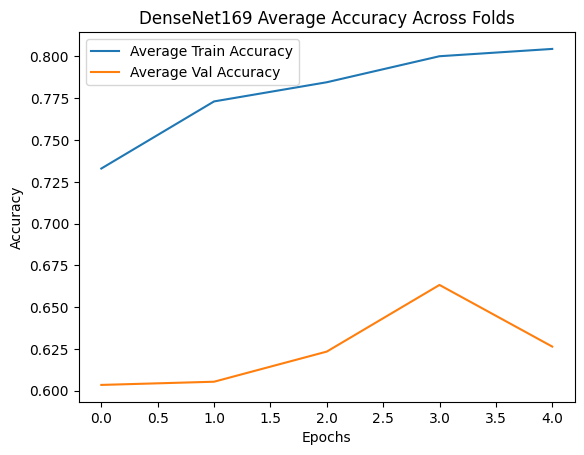

23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 604ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 522ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 497ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 491ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 490ms/step


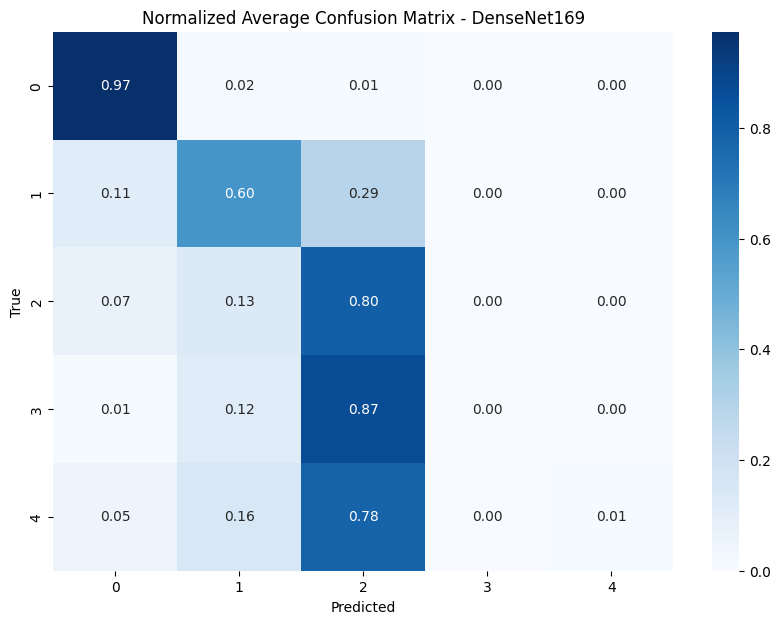

In [22]:
# DenseNet169
base_model_DenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
DenseNet169_model = add_dense_layer(base_model_DenseNet169)
DenseNet169_model = compile_model_with_dense(DenseNet169_model)

# Train DenseNet169 model using cross-validation
DenseNet169_history = cross_validate_model(DenseNet169_model, train_images, train_labels, folds=FOLDS, epochs=EPOCHS)

# Visualize Accuracy for all folds for DenseNet169
avg_train_accuracy_DenseNet169 = np.mean([history.history['accuracy'] for history in DenseNet169_history], axis=0)
avg_val_accuracy_DenseNet169 = np.mean([history.history['val_accuracy'] for history in DenseNet169_history], axis=0)

# Plot average accuracy for all folds for DenseNet169
plt.plot(avg_train_accuracy_DenseNet169, label='Average Train Accuracy')
plt.plot(avg_val_accuracy_DenseNet169, label='Average Val Accuracy')

plt.title('DenseNet169 Average Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion matrix for DenseNet169 during testing
conf_matrix_sum_DenseNet169 = np.zeros((5, 5))  # Adjust size if you have a different number of classes

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(train_images):
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Predict using DenseNet169 model
    y_pred_DenseNet169 = np.argmax(DenseNet169_model.predict(X_val), axis=1)

    # Compute confusion matrix for DenseNet169 model
    conf_matrix_DenseNet169 = confusion_matrix(y_val, y_pred_DenseNet169, labels=np.arange(5))
    conf_matrix_sum_DenseNet169 += conf_matrix_DenseNet169

# Average and normalize the confusion matrix
conf_matrix_avg_DenseNet169 = conf_matrix_sum_DenseNet169 / kf.get_n_splits()
conf_matrix_norm_avg_DenseNet169 = conf_matrix_avg_DenseNet169 / conf_matrix_avg_DenseNet169.sum(axis=1)[:, np.newaxis]

# Plot normalized average confusion matrix for DenseNet169
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_norm_avg_DenseNet169, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Average Confusion Matrix - DenseNet169')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Extract final metrics from history
train_accuracy = DenseNet169_history.history['accuracy'][-1]
val_accuracy = DenseNet169_history.history['val_accuracy'][-1]
train_precision = DenseNet169_history.history['precision'][-1]
val_precision = DenseNet169_history.history['val_precision'][-1]
train_recall = DenseNet169_history.history['recall'][-1]
val_recall = DenseNet169_history.history['val_recall'][-1]
train_loss = DenseNet169_history.history['loss'][-1]
val_loss = DenseNet169_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)

Training Fold 1...
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5821 - loss: 1.4009 - val_accuracy: 0.4823 - val_loss: 368.5879
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7334 - loss: 0.7535 - val_accuracy: 0.7056 - val_loss: 22.3357
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 57s 992ms/step - accuracy: 0.7566 - loss: 0.6774 - val_accuracy: 0.6477 - val_loss: 1.4703
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 58s 994ms/step - accuracy: 0.7553 - loss: 0.6288 - val_accuracy: 0.7384 - val_loss: 0.7900
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 57s 992ms/step - accuracy: 0.7793 - loss: 0.6015 - val_accuracy: 0.7171 - val_loss: 1.1791
Training Fold 2...
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7453 - loss: 0.7259 - val_accuracy: 0.5057 - val_loss: 123.0156
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 58s 995ms/step - accuracy: 0.7615 - loss: 0.8351 - val_accuracy: 0.5576 - val_loss: 3.5877
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 58s 997ms/step - accuracy: 0.7306

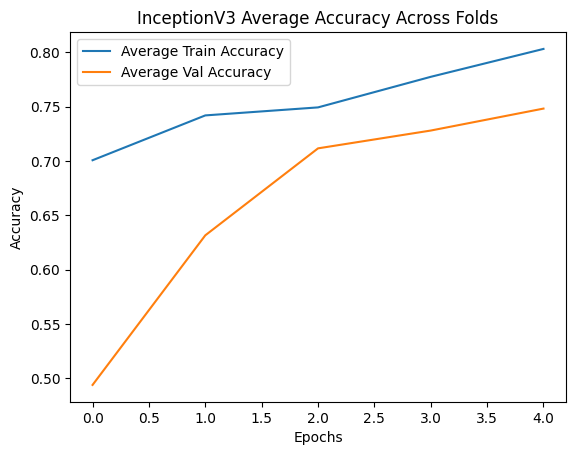

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step


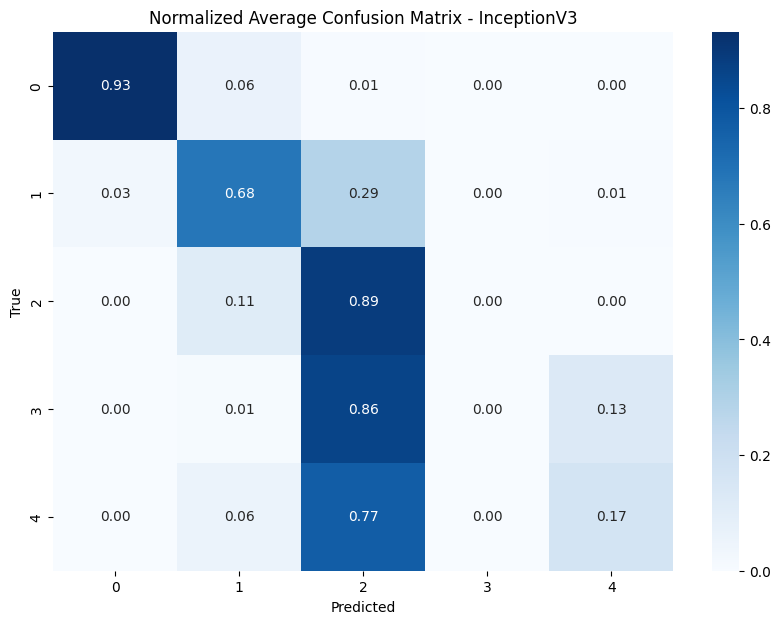

In [23]:
# InceptionV3
base_model_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
InceptionV3_model = add_dense_layer(base_model_InceptionV3)
InceptionV3_model = compile_model_with_dense(InceptionV3_model)

# Train InceptionV3 model using cross-validation
InceptionV3_history = cross_validate_model(InceptionV3_model, train_images, train_labels, folds=FOLDS, epochs=EPOCHS)

# Visualize Accuracy for all folds for InceptionV3
avg_train_accuracy_InceptionV3 = np.mean([history.history['accuracy'] for history in InceptionV3_history], axis=0)
avg_val_accuracy_InceptionV3 = np.mean([history.history['val_accuracy'] for history in InceptionV3_history], axis=0)

# Plot average accuracy for all folds for InceptionV3
plt.plot(avg_train_accuracy_InceptionV3, label='Average Train Accuracy')
plt.plot(avg_val_accuracy_InceptionV3, label='Average Val Accuracy')

plt.title('InceptionV3 Average Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion matrix for InceptionV3 during testing
conf_matrix_sum_InceptionV3 = np.zeros((5, 5))  # Adjust size if you have a different number of classes

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(train_images):
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Predict using InceptionV3 model
    y_pred_InceptionV3 = np.argmax(InceptionV3_model.predict(X_val), axis=1)

    # Compute confusion matrix for InceptionV3 model
    conf_matrix_InceptionV3 = confusion_matrix(y_val, y_pred_InceptionV3, labels=np.arange(5))
    conf_matrix_sum_InceptionV3 += conf_matrix_InceptionV3

# Average and normalize the confusion matrix
conf_matrix_avg_InceptionV3 = conf_matrix_sum_InceptionV3 / kf.get_n_splits()
conf_matrix_norm_avg_InceptionV3 = conf_matrix_avg_InceptionV3 / conf_matrix_avg_InceptionV3.sum(axis=1)[:, np.newaxis]

# Plot normalized average confusion matrix for InceptionV3
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_norm_avg_InceptionV3, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Average Confusion Matrix - InceptionV3')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Extract final metrics from history
train_accuracy = InceptionV3_history.history['accuracy'][-1]
val_accuracy = InceptionV3_history.history['val_accuracy'][-1]
train_precision = InceptionV3_history.history['precision'][-1]
val_precision = InceptionV3_history.history['val_precision'][-1]
train_recall = InceptionV3_history.history['recall'][-1]
val_recall = InceptionV3_history.history['val_recall'][-1]
train_loss = InceptionV3_history.history['loss'][-1]
val_loss = InceptionV3_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)


Training Fold 1...
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.6612 - loss: 1.0814 - val_accuracy: 0.6729 - val_loss: 1.2367
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7798 - loss: 0.6336 - val_accuracy: 0.6259 - val_loss: 1.1031
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8305 - loss: 0.4462 - val_accuracy: 0.7242 - val_loss: 1.1004
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8542 - loss: 0.3832 - val_accuracy: 0.7553 - val_loss: 0.8250
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8831 - loss: 0.3178 - val_accuracy: 0.7335 - val_loss: 0.9191
Training Fold 2...
Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7552 - loss: 0.7922 - val_accuracy: 0.8263 - val_loss: 0.4928
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8085 - loss: 0.5383 - val_accuracy: 0.8176 - val_loss: 0.4599
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8617 - loss: 0.

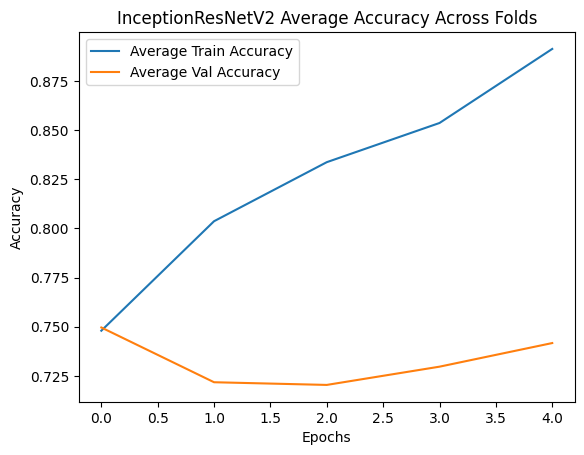

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 540ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 435ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 404ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 404ms/step


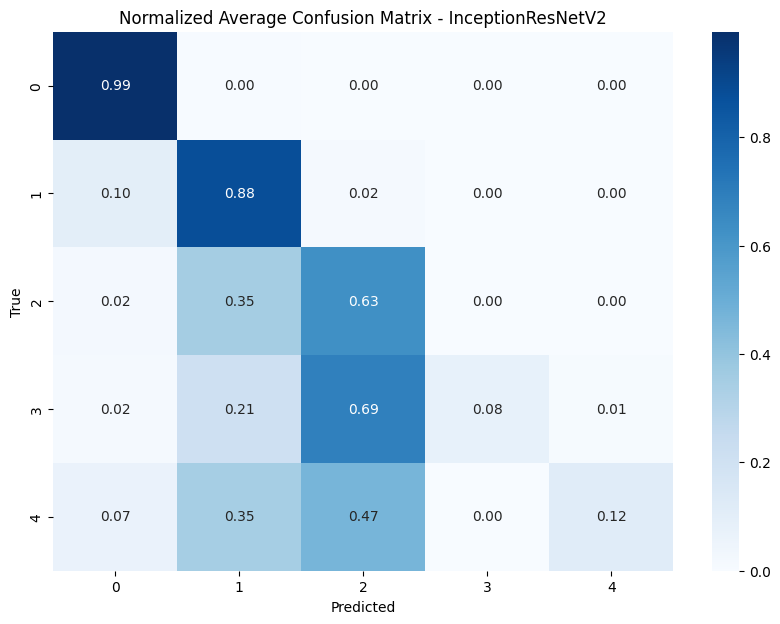

In [24]:
# InceptionResNetV2
base_model_InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
InceptionResNetV2_model = add_dense_layer(base_model_InceptionResNetV2)
InceptionResNetV2_model = compile_model_with_dense(InceptionResNetV2_model)

# Train InceptionResNetV2 model using cross-validation
InceptionResNetV2_history = cross_validate_model(InceptionResNetV2_model, train_images, train_labels, folds=FOLDS, epochs=EPOCHS)

# Visualize Accuracy for all folds for InceptionResNetV2
avg_train_accuracy_InceptionResNetV2 = np.mean([history.history['accuracy'] for history in InceptionResNetV2_history], axis=0)
avg_val_accuracy_InceptionResNetV2 = np.mean([history.history['val_accuracy'] for history in InceptionResNetV2_history], axis=0)

# Plot average accuracy for all folds for InceptionResNetV2
plt.plot(avg_train_accuracy_InceptionResNetV2, label='Average Train Accuracy')
plt.plot(avg_val_accuracy_InceptionResNetV2, label='Average Val Accuracy')

plt.title('InceptionResNetV2 Average Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion matrix for InceptionResNetV2 during testing
conf_matrix_sum_InceptionResNetV2 = np.zeros((5, 5))  # Adjust size if you have a different number of classes

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(train_images):
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Predict using InceptionResNetV2 model
    y_pred_InceptionResNetV2 = np.argmax(InceptionResNetV2_model.predict(X_val), axis=1)

    # Compute confusion matrix for InceptionResNetV2 model
    conf_matrix_InceptionResNetV2 = confusion_matrix(y_val, y_pred_InceptionResNetV2, labels=np.arange(5))
    conf_matrix_sum_InceptionResNetV2 += conf_matrix_InceptionResNetV2

# Average and normalize the confusion matrix
conf_matrix_avg_InceptionResNetV2 = conf_matrix_sum_InceptionResNetV2 / kf.get_n_splits()
conf_matrix_norm_avg_InceptionResNetV2 = conf_matrix_avg_InceptionResNetV2 / conf_matrix_avg_InceptionResNetV2.sum(axis=1)[:, np.newaxis]

# Plot normalized average confusion matrix for InceptionResNetV2
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_norm_avg_InceptionResNetV2, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Average Confusion Matrix - InceptionResNetV2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Extract final metrics from history
train_accuracy = InceptionResNetV2_history.history['accuracy'][-1]
val_accuracy = InceptionResNetV2_history.history['val_accuracy'][-1]
train_precision = InceptionResNetV2_history.history['precision'][-1]
val_precision = InceptionResNetV2_history.history['val_precision'][-1]
train_recall = InceptionResNetV2_history.history['recall'][-1]
val_recall = InceptionResNetV2_history.history['val_recall'][-1]
train_loss = InceptionResNetV2_history.history['loss'][-1]
val_loss = InceptionResNetV2_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)

In [ ]:
# Ensemble Prediction (Voting Ensemble) across validation sets
def ensemble_predict_cross_validation(models, X_val_list):
    predictions = []
    for model, X_val in zip(models, X_val_list):
        pred = np.argmax(model.predict(X_val), axis=1)
        predictions.append(pred)
    predictions = np.array(predictions)
    ensemble_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
    return ensemble_pred

# Cross-validation with ensemble model
ensemble_models = [mobilenet_model, xception_model]  # Add more trained models
kf = KFold(n_splits=5, shuffle=True, random_state=42)
conf_matrix_sum_ensemble = np.zeros((5, 5))  # Adjust size if you have a different number of classes

for train_index, val_index in kf.split(train_images):
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]
    
    # Make ensemble predictions for this fold
    ensemble_pred = ensemble_predict_cross_validation(ensemble_models, [X_val, X_val])
    
    # Compute and sum confusion matrix
    conf_matrix_ensemble = confusion_matrix(y_val, ensemble_pred)
    conf_matrix_sum_ensemble += conf_matrix_ensemble

# Average and normalize the confusion matrix
conf_matrix_avg_ensemble = conf_matrix_sum_ensemble / kf.get_n_splits()
conf_matrix_norm_avg_ensemble = conf_matrix_avg_ensemble / conf_matrix_avg_ensemble.sum(axis=1)[:, np.newaxis]

# Plot normalized average confusion matrix for ensemble
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_norm_avg_ensemble, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Average Confusion Matrix - Ensemble')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()